## <span style='color:purple '> 1. Import Libraries </span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#set floating point precision option for pandas
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import seaborn as sns
sns.set_context('paper', font_scale=1.3)
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller, pacf

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error
%matplotlib inline

import math

#Import necessary functions from keras
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

#to read zipfile
import zipfile

#to check missing values
import missingno as mn

import scipy.stats as stats

C:\Users\Prerana\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## <span style ='color:purple'> 2. Import Data </span>

In [2]:
zip_file_path = 'cosumption_data.zip'
file_name = 'household_power_consumption.txt'

with zipfile.ZipFile(zip_file_path,'r') as folder:
    file_list = folder.namelist()
    for file in file_list:
        if file == file_name:
            with folder.open(file_name) as csv_file:
                df = pd.read_csv(csv_file, delimiter=';')
    

In [3]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


In [4]:
df.tail()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075254,26/11/2010,20:58:00,0.9460,0.0000,240.4300,4.0000,0.0000,0.0000,0.0000
2075255,26/11/2010,20:59:00,0.9440,0.0000,240.0000,4.0000,0.0000,0.0000,0.0000
2075256,26/11/2010,21:00:00,0.9380,0.0000,239.8200,3.8000,0.0000,0.0000,0.0000
2075257,26/11/2010,21:01:00,0.9340,0.0000,239.7000,3.8000,0.0000,0.0000,0.0000
2075258,26/11/2010,21:02:00,0.9320,0.0000,239.5500,3.8000,0.0000,0.0000,0.0000


In [5]:
df.shape

(2075259, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [7]:
df.isna().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

## <span style ='color:purple'> 3. Feature Engineering </span>

* Convert 'Date' and 'Time' column to single 'Datetime' column

In [8]:
df['Datetime'] = pd.to_datetime(df['Date']+' '+df['Time'])

In [9]:
df['Datetime'].dtype

dtype('<M8[ns]')

* Convert other features to numeric format

In [10]:
for feat in df.columns.drop(['Date','Time','Datetime']):
    df[feat] = pd.to_numeric(df[feat],errors='coerce')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date                   object        
 1   Time                   object        
 2   Global_active_power    float64       
 3   Global_reactive_power  float64       
 4   Voltage                float64       
 5   Global_intensity       float64       
 6   Sub_metering_1         float64       
 7   Sub_metering_2         float64       
 8   Sub_metering_3         float64       
 9   Datetime               datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 158.3+ MB


* Handling Missing Values

In [12]:
df.isna().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
Datetime                     0
dtype: int64

<AxesSubplot:>

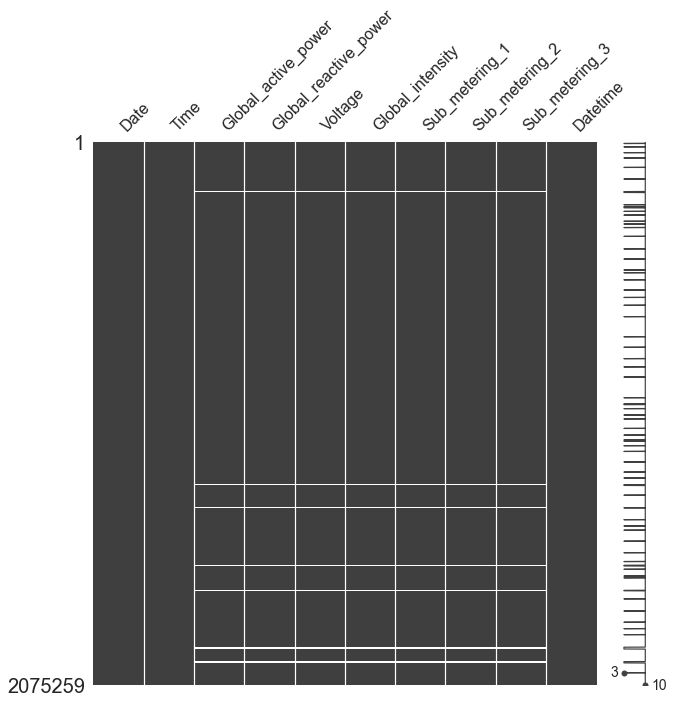

In [13]:
mn.matrix(df,figsize=(10,10))

In [14]:
print('Missing data :',round((df['Global_active_power'].isna().sum()/df.shape[0])*100,2),'%')

Missing data : 1.25 %


* data is missing in chunks and less that 5% data is missing so we can drop the data

In [15]:
df.dropna(inplace=True)

In [16]:
df.shape

(2049280, 10)

* Create new columns for year, quarter, month, and day

In [17]:
df['year'] = df['Datetime'].apply(lambda x: x.year)
df['quarter'] = df['Datetime'].apply(lambda x: x.quarter)
df['month'] = df['Datetime'].apply(lambda x: x.month)
df['day'] = df['Datetime'].apply(lambda x: x.day)

* selecting necessary columns only 

In [18]:
df_2 = df.loc[:,['Datetime','Global_active_power','year','quarter','month','day']]

* Sort data by datetime in ascending order

In [19]:
df_2.sort_values('Datetime',inplace=True, ascending=True)

* Reset the index

In [20]:
df_2 = df_2.reset_index(drop=True)

* Create new column 'weekday' that indicates if the day is weekday or weekend

In [21]:
df_2['weekday'] = df_2['Datetime'].apply(lambda x:x.weekday()<5).astype(int)

In [22]:
print("Minimun datetime :", df_2.Datetime.min())
print("Maximum datetime :", df_2.Datetime.max())

Minimun datetime : 2006-12-16 17:24:00
Maximum datetime : 2010-12-11 23:59:00


In [23]:
df_2.head()

,Datetime,Global_active_power,year,quarter,month,day,weekday
0,2006-12-16 17:24:00,4.2160,2006,4,12,16,0
1,2006-12-16 17:25:00,5.3600,2006,4,12,16,0
2,2006-12-16 17:26:00,5.3740,2006,4,12,16,0
3,2006-12-16 17:27:00,5.3880,2006,4,12,16,0
4,2006-12-16 17:28:00,3.6660,2006,4,12,16,0


In [24]:
df_2.tail()

,Datetime,Global_active_power,year,quarter,month,day,weekday
2049275,2010-12-11 23:55:00,0.6900,2010,4,12,11,0
2049276,2010-12-11 23:56:00,0.6880,2010,4,12,11,0
2049277,2010-12-11 23:57:00,0.6880,2010,4,12,11,0
2049278,2010-12-11 23:58:00,0.6880,2010,4,12,11,0
2049279,2010-12-11 23:59:00,0.6880,2010,4,12,11,0


## <span style='color:purple'> 4. Testing for Normality</span>

* Testing for Normality

    - We will use D'Agostino's K^2 test to determine if our data is normally distributed.
    - If p <= alpha, will reject the null hypothesis (H0) and conclude the the data is not normally distributed.
    - If p > alpha, will accept null hypothesis and conclude that the data is normal.

In [25]:
#calculate the test statistics and p-value
stat, p = stats.normaltest(df_2.Global_active_power)

print('Statistics = %.3f, p=%.3f' %(stat,p))

alpha = 0.05

if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian(reject H0)')

Statistics = 724881.795, p=0.000
Data does not look Gaussian(reject H0)


Kurtosis of normal distribution : 4.218671866132123
Skewness of normal distribution : 1.7862320846320832


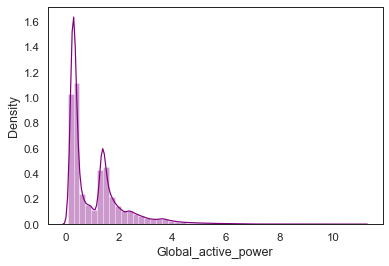

In [26]:
sns.distplot(df_2['Global_active_power'], color='purple')
print('Kurtosis of normal distribution : {}'.format(stats.kurtosis(df_2['Global_active_power'])))
print('Skewness of normal distribution : {}'.format(stats.skew(df_2['Global_active_power'])))

- The kurtosis is positive that indicates heavier tail
- Skewness is greater than 1 that indicates data is highly skewed

## <span style ='color:purple'> 5. Exploratory Data Analysis </span> 

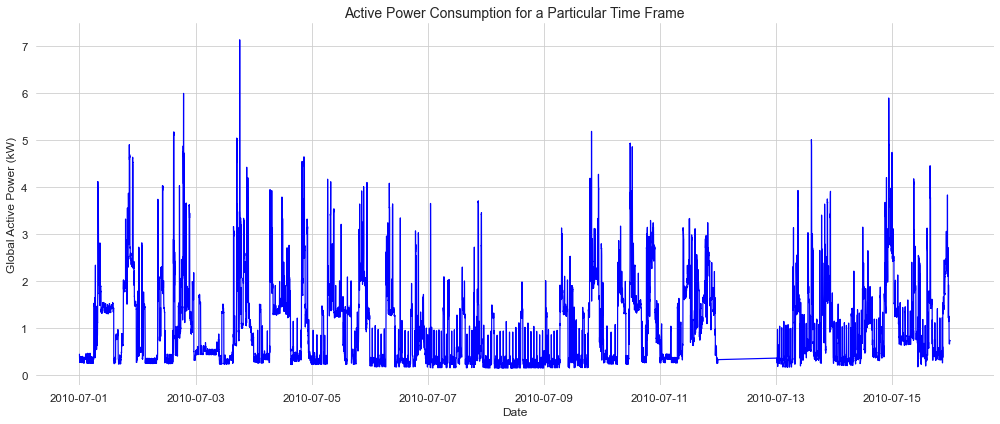

In [27]:
data = df_2[(df_2['Datetime'] >= '2010-07-01') & (df_2['Datetime'] < '2010-07-16')]

plt.figure(figsize=(14,6))
plt.plot(data['Datetime'],data['Global_active_power'],color='blue')
plt.ylabel('Global Active Power (kW)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title('Active Power Consumption for a Particular Time Frame', fontsize=14)
plt.tight_layout()
plt.grid(True)
sns.despine(bottom=True,left=True)
plt.show()

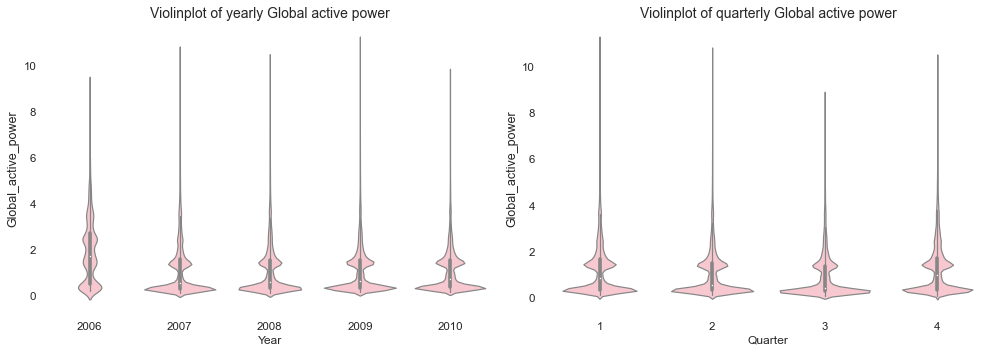

In [28]:
#Plotting violinplot for Global active power
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.violinplot(x='year', y='Global_active_power',data=df_2, color='pink')
plt.xlabel('Year',fontsize=12)
plt.title('Violinplot of yearly Global active power', fontsize=14)
sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.subplot(1,2,2)
sns.violinplot(x='quarter', y='Global_active_power', data=df_2, color='pink')
plt.xlabel('Quarter', fontsize=12)
plt.title('Violinplot of quarterly Global active power', fontsize=14)
sns.despine(left=True, bottom=True)
plt.tight_layout()

                         count      mean    std       min       25%       50%  \
Global_active_power 20159.0000    0.9794 0.8599    0.1540    0.3320    0.5940   
year                20159.0000 2010.0000 0.0000 2010.0000 2010.0000 2010.0000   
quarter             20159.0000    3.0000 0.0000    3.0000    3.0000    3.0000   
month               20159.0000    7.0000 0.0000    7.0000    7.0000    7.0000   
day                 20159.0000    7.7139 4.3330    1.0000    4.0000    7.0000   
weekday             20159.0000    0.7143 0.4518    0.0000    0.0000    1.0000   

                          75%       max  
Global_active_power    1.4340    7.1400  
year                2010.0000 2010.0000  
quarter                3.0000    3.0000  
month                  7.0000    7.0000  
day                   11.0000   15.0000  
weekday                1.0000    1.0000  


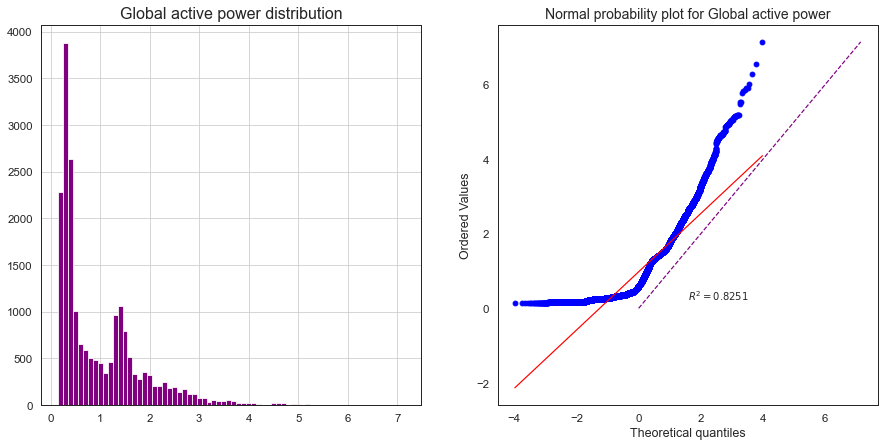

In [29]:
#ploting histogram and normal probability plot for Global active power
plt.figure(figsize=(15,7))

#histogram
plt.subplot(1,2,1)
data['Global_active_power'].hist(bins=70,color='purple')
plt.title('Global active power distribution', fontsize=16)

#probability plot
plt.subplot(1,2,2)
stats.probplot(data['Global_active_power'], plot=plt, fit=True, rvalue=True)

plt.plot([0, max(data['Global_active_power'])],[0,max(data['Global_active_power'])],color='purple',linestyle='--')
plt.title('Normal probability plot for Global active power', fontsize=14)

print(data.describe().T)

In [30]:
data = df_2[['Datetime','Global_active_power']]
data

,Datetime,Global_active_power
0,2006-12-16 17:24:00,4.2160
1,2006-12-16 17:25:00,5.3600
2,2006-12-16 17:26:00,5.3740
3,2006-12-16 17:27:00,5.3880
4,2006-12-16 17:28:00,3.6660
...,...,...
2049275,2010-12-11 23:55:00,0.6900
2049276,2010-12-11 23:56:00,0.6880
2049277,2010-12-11 23:57:00,0.6880
2049278,2010-12-11 23:58:00,0.6880


In [31]:
data.set_index('Datetime',inplace=True)

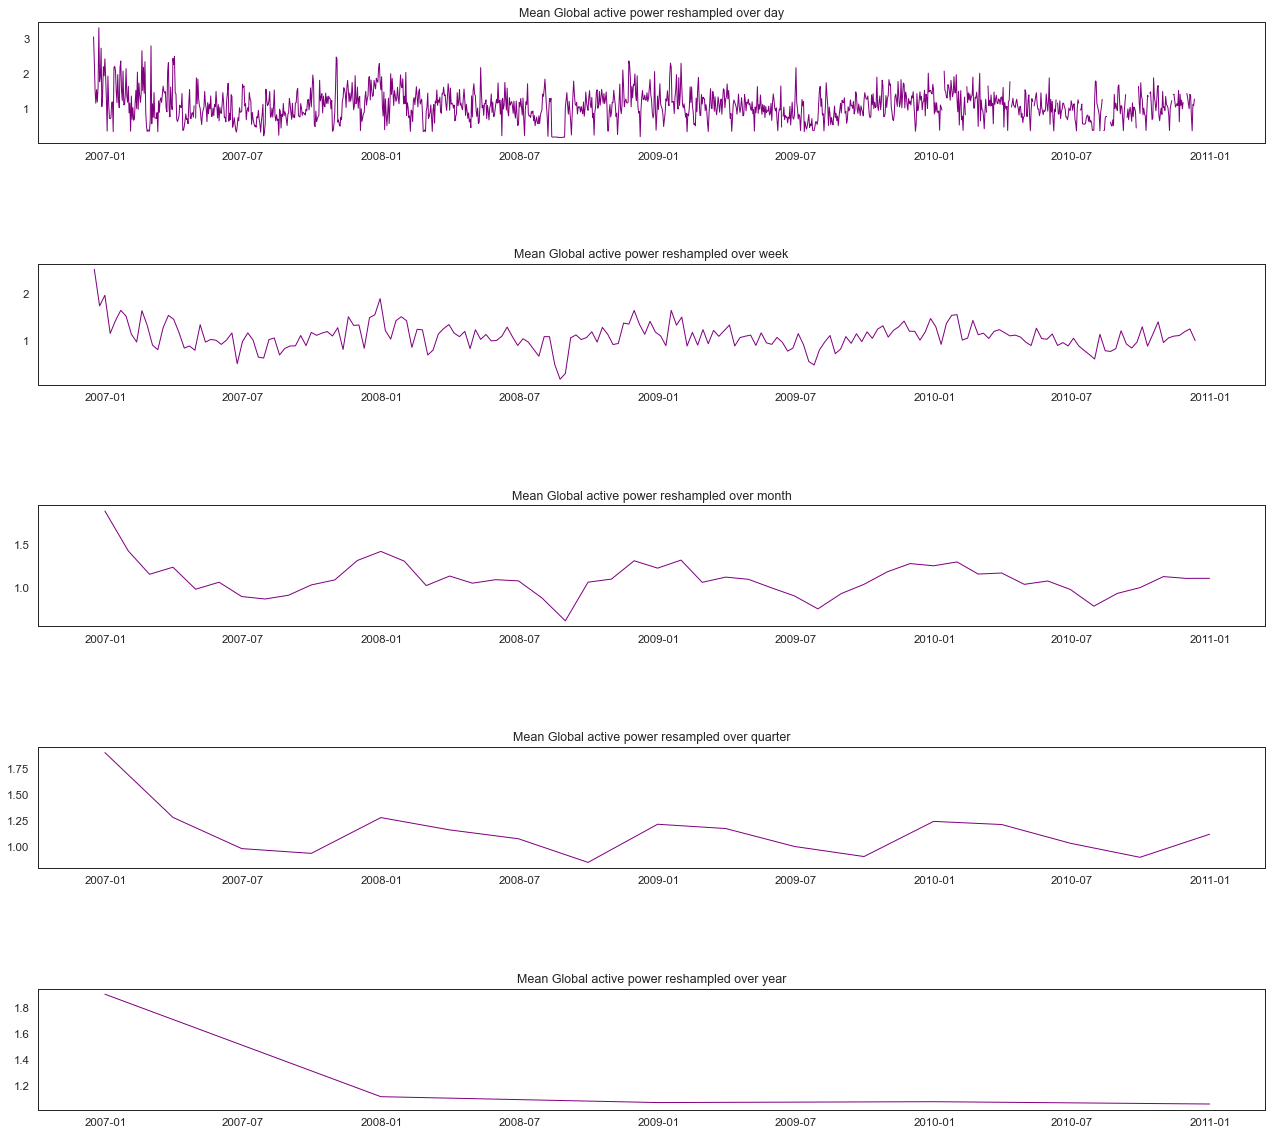

In [32]:
fig = plt.figure(figsize=(22,20))
fig.subplots_adjust(hspace=1)

ax1 = fig.add_subplot(5,1,1)
ax1.plot(data['Global_active_power'].resample('D').mean(), linewidth=1, color='purple')
ax1.set_title('Mean Global active power reshampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2,sharex=ax1)
ax2.plot(data['Global_active_power'].resample('W').mean(), linewidth=1, color='purple')
ax2.set_title('Mean Global active power reshampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3,sharex=ax1)
ax3.plot(data['Global_active_power'].resample('M').mean(), linewidth=1, color='purple')
ax3.set_title('Mean Global active power reshampled over month')
ax3.tick_params(axis='both', which='major')

ax4 = fig.add_subplot(5,1,4,sharex=ax1)
ax4.plot(data['Global_active_power'].resample('Q').mean(), linewidth=1, color='purple')
ax4.set_title('Mean Global active power resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5 = fig.add_subplot(5,1,5,sharex=ax1)
ax5.plot(data['Global_active_power'].resample('A').mean(), linewidth=1, color='purple')
ax5.set_title('Mean Global active power reshampled over year')
ax5.tick_params(axis='both', which='major')

* The overall trend in our time series data does not show a consistent increase or decrease
* The peak average power consumption was observed prior 2007, but then there was a noticeable drop in 2008 and it has remained relatively stable since then

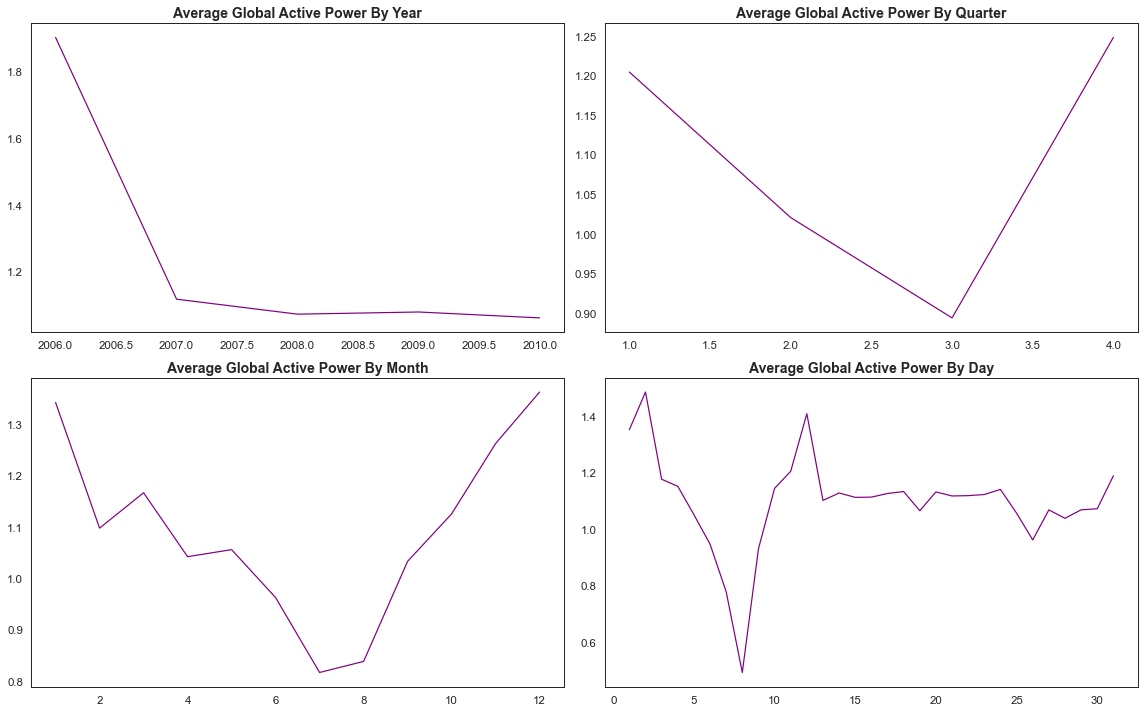

In [33]:
plt.figure(figsize=(16,10))
plt.subplot(2,2,1)

grouped_by_year = df_2.groupby('year').Global_active_power.agg('mean')
grouped_by_year.plot(color='purple')
plt.xlabel('')
plt.title('Average Global Active Power By Year', fontsize=14, fontweight='bold')

plt.subplot(2,2,2)
grouped_by_quarter = df_2.groupby('quarter').Global_active_power.agg('mean')
grouped_by_quarter.plot(color='purple')
plt.xlabel('')
plt.title('Average Global Active Power By Quarter', fontsize=14, fontweight='bold')

plt.subplot(2,2,3)
grouped_by_month = df_2.groupby('month').Global_active_power.agg('mean')
grouped_by_month.plot(color='purple')
plt.xlabel('')
plt.title('Average Global Active Power By Month', fontsize=14, fontweight='bold')

plt.subplot(2,2,4)
grouped_by_day = df_2.groupby('day').Global_active_power.agg('mean')
grouped_by_day.plot(color='purple')
plt.xlabel('')
plt.title('Average Global Active Power By Day', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

* Average power consumption was heigher prior 2007 and remained consistent then
* lowest average power consumption was recorded in 3rd quarter
* moth of july and august recorded lowest average power consumption
* lowest daily average cosumption is recorded on 8th of month

## <span style = 'color:purple'> 6. Testing for stationarity of the time series </span>

In [34]:
#Dickey-fuller test

def test_stationarity(timeseries):
    
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(20,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='purple', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling mean')
    std = plt.plot(rolstd, color='cyan', label='Rollind std')
    plt.legend(loc='best')
    plt.title('Rolling mean & standard deviation of Global active power')
    plt.show()
    
    print("Result of Dickey-fuller test")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                        index=['Test Statistic','p-val','#Lags used','No of obeservations used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

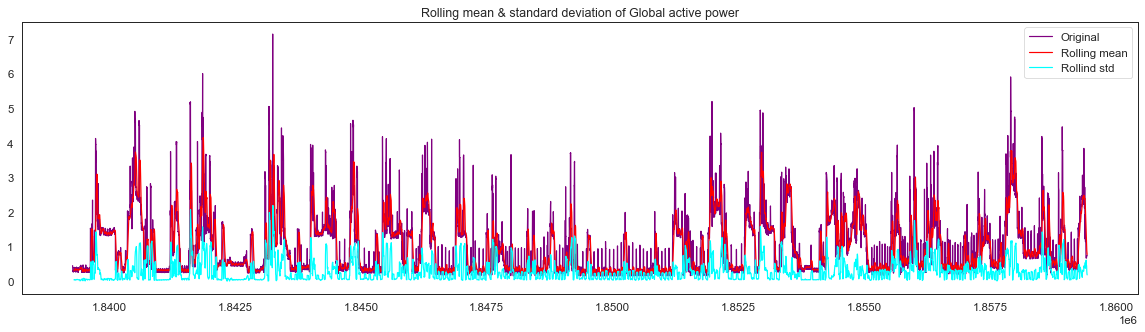

Result of Dickey-fuller test
Test Statistic               -12.4771
p-val                          0.0000
#Lags used                    18.0000
No of obeservations used   20140.0000
Critical Value (1%)           -3.4307
Critical Value (5%)           -2.8617
Critical Value (10%)          -2.5668
dtype: float64


In [37]:
data2 = df_2[(df_2['Datetime'] >= '2010-07-01') & (df_2['Datetime'] < '2010-07-16')]
test_stationarity(data2['Global_active_power'])

## <span style='color:purple'> 7. Modelling & Evaluation </span>

In [40]:
dataset = df_2['Global_active_power'].values.astype('float32')
dataset = np.reshape(dataset,(-1,1))
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset)*0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [41]:
def create_dataset(dataset, look_back=1):
    X,Y = [],[]
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),0]
        X.append(a)
        Y.append(dataset[i+look_back,0])
    return np.array(X), np.array(Y)

In [42]:
look_back = 30
X_train, Y_train = create_dataset(train,look_back)
X_test, Y_test = create_dataset(test,look_back)

In [43]:
X_train.shape, Y_train.shape

((1639393, 30), (1639393,))

In [44]:
X_train = np.reshape(X_train, (X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],1,X_test.shape[1]))

In [45]:
X_train.shape

(1639393, 1, 30)

#### LSTM Model

In [46]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=1240, validation_data=(X_test,Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=4)], verbose=1, shuffle=False)
model.summary()



Epoch 1/20

1323/1323 [==============================] - 17s 11ms/step - loss: 0.0012 - val_loss: 4.2319e-04
Epoch 2/20
1323/1323 [==============================] - 14s 10ms/step - loss: 6.6401e-04 - val_loss: 4.1562e-04
Epoch 3/20
1323/1323 [==============================] - 14s 10ms/step - loss: 6.4815e-04 - val_loss: 4.1456e-04
Epoch 4/20
1323/1323 [==============================] - 13s 10ms/step - loss: 6.3589e-04 - val_loss: 4.1365e-04
Epoch 5/20
1323/1323 [==============================] - 12s 9ms/step - loss: 6.3351e-04 - val_loss: 4.0810e-04
Epoch 6/20
1323/1323 [==============================] - 12s 9ms/step - loss: 6.2900e-04 - val_loss: 4.0736e-04
Epoch 7/20
1323/1323 [==============================] - 14s 10ms/step - loss: 6.2737e-04 - val_loss: 4.0482e-04
Epoch 8/20
1323/1323 [==============================] - 14s 10ms/step - loss: 6.2800e-04 - val_loss: 4.0333e-04
Epoch 9/20
1323/1323 [==============================] - 14s 10ms/step - loss: 6.2479e-04 - val_loss: 4.0736

#### Evaluation

In [47]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error :', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error :', np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error :', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error :', np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

12808/12808 [==============================] - 29s 2ms/step
Train Mean Absolute Error : 0.0928634005494707
Train Root Mean Squared Error : 0.2679484735854144
Test Mean Absolute Error : 0.07823704979532757
Test Root Mean Squared Error : 0.22092160674303832


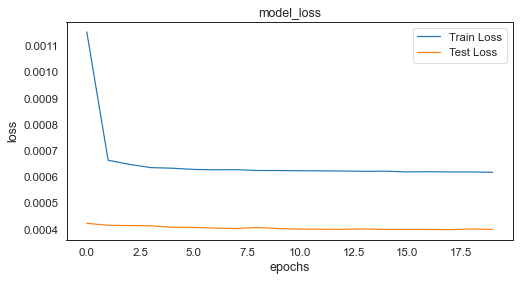

In [49]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

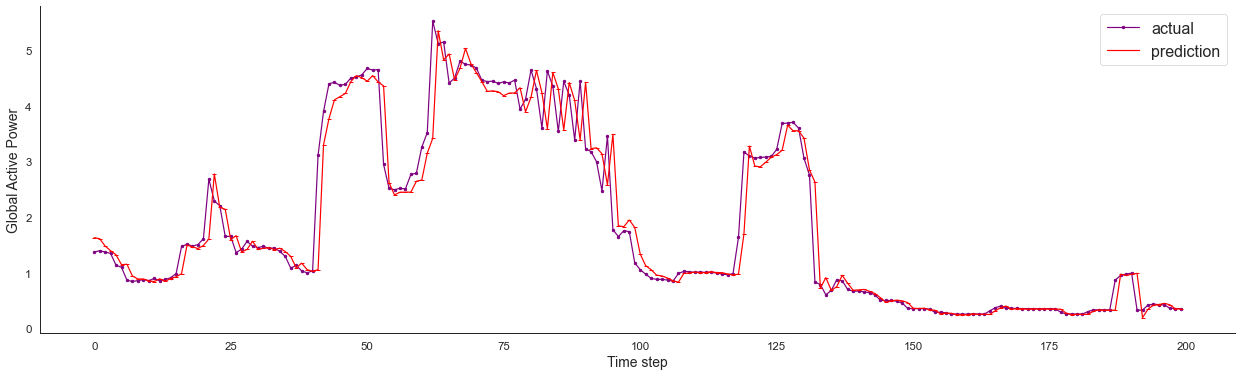

In [51]:
aa = [x for x in range(200)]
plt.figure(figsize=(20,6))
plt.plot(aa, Y_test[0][:200], marker='.', label='actual', color='purple')
plt.plot(aa, test_predict[:,0][:200], marker='_', label='prediction', color='red')

sns.despine(top=True)

plt.subplots_adjust(left=0.07)
plt.ylabel('Global Active Power', fontsize=14)
plt.xlabel('Time step', fontsize=14)
plt.legend(fontsize=16)
plt.show()

## *END*